# SyriaTel Customer Analysis

__By: Brian Lee__

***

## Business problem

__SyriaTel__ telecommunications company has hired us to analyze the causes to customer churn. __Churn__ is whether a customer will stop doing business with the company. __The goal is to maintain SyriaTel customers in order to stably increase company profits and to build good customer reputation for future clientele.__ We are trying to predict the likelihood of a customer churn based on a user's communication usage, plans, and other related factors. 
***
Business Questions to have in mind:
* Do we need to improve our current customer plans?
* How does customer call usage affect their decisions to stay with SyriaTel?
* How is our response to customer needs?

## Data Understanding

This project uses the SyriaTel customer dataset, which can be found in 'telecoms.csv' in the 'data' folder. 

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix,recall_score,precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support,f1_score,fbeta_score
from sklearn.metrics import classification_report, plot_roc_curve, plot_confusion_matrix, recall_score, make_scorer
from sklearn.linear_model import LogisticRegression 
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('data/telecoms.csv')
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## Data Preparation

Let's quickly examine the dataset and clean it up for proper analysis and modeling

In [3]:
display(df.info())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

None

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [4]:
# Adjust column names with '_'
df.columns = df.columns.str.replace(' ','_')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account_length          3333 non-null   int64  
 2   area_code               3333 non-null   int64  
 3   phone_number            3333 non-null   object 
 4   international_plan      3333 non-null   object 
 5   voice_mail_plan         3333 non-null   object 
 6   number_vmail_messages   3333 non-null   int64  
 7   total_day_minutes       3333 non-null   float64
 8   total_day_calls         3333 non-null   int64  
 9   total_day_charge        3333 non-null   float64
 10  total_eve_minutes       3333 non-null   float64
 11  total_eve_calls         3333 non-null   int64  
 12  total_eve_charge        3333 non-null   float64
 13  total_night_minutes     3333 non-null   float64
 14  total_night_calls       3333 non-null   

In [5]:
# Find missing values columns
df.isna().sum()

state                     0
account_length            0
area_code                 0
phone_number              0
international_plan        0
voice_mail_plan           0
number_vmail_messages     0
total_day_minutes         0
total_day_calls           0
total_day_charge          0
total_eve_minutes         0
total_eve_calls           0
total_eve_charge          0
total_night_minutes       0
total_night_calls         0
total_night_charge        0
total_intl_minutes        0
total_intl_calls          0
total_intl_charge         0
customer_service_calls    0
churn                     0
dtype: int64

* No missing values found.

Phone numbers are just unique identifiers. Does not provide additional information. Could drop it

In [6]:
# Drop phone_number
df.drop('phone_number', axis=1, inplace=True)

In [7]:
# Values for area_code
df.area_code.value_counts()

415    1655
510     840
408     838
Name: area_code, dtype: int64

Taking a look at the area_code values show that there are only 3 area codes (San Francisco area), despite the data being declared for several different states. It will be better to drop the area codes in this case. 

In [8]:
# Drop area_code column
df.drop('area_code', axis = 1, inplace=True)

Let's change the categorical columns to integers for easier analysis

In [9]:
# Change churn and plans to int
df['churn'] *= 1

df['international_plan'] = df['international_plan'].apply(lambda x: 1 if x=='yes' else 0)
df['voice_mail_plan'] = df['voice_mail_plan'].apply(lambda x: 1 if x=='yes' else 0)

df[['churn', 'international_plan', 'voice_mail_plan']].astype(int)

,churn,international_plan,voice_mail_plan
0,0,0,1
1,0,0,1
2,0,0,0
3,0,1,0
4,0,1,0
...,...,...,...
3328,0,0,1
3329,0,0,0
3330,0,0,0
3331,0,1,0


In [10]:
df.head()

,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,KS,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


## Feature Engineering

Let's make a few features that will be useful to examine on a customer's overall phone usage. 

In [11]:
# Creating a column for total customer charges by adding all the individual charges
df['total_customer_charges'] = df['total_day_charge'] + df['total_eve_charge'] + df['total_night_charge'] + df['total_intl_charge']
df['total_customer_charges'].head()

0    75.56
1    59.24
2    62.29
3    66.80
4    52.09
Name: total_customer_charges, dtype: float64

In [12]:
# Doing the same methood for total calls and minutes
df['total_customer_calls'] = df['total_day_calls'] + df['total_eve_calls'] + df['total_night_calls'] + df['total_intl_calls']
df['total_customer_minutes'] = df['total_day_minutes'] + df['total_eve_minutes'] + df['total_night_minutes'] + df['total_intl_minutes']
df.head()

,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,...,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,total_customer_charges,total_customer_calls,total_customer_minutes
0,KS,128,0,1,25,265.1,110,45.07,197.4,99,...,91,11.01,10.0,3,2.70,1,0,75.56,303,717.2
1,OH,107,0,1,26,161.6,123,27.47,195.5,103,...,103,11.45,13.7,3,3.70,1,0,59.24,332,625.2
2,NJ,137,0,0,0,243.4,114,41.38,121.2,110,...,104,7.32,12.2,5,3.29,0,0,62.29,333,539.4
3,OH,84,1,0,0,299.4,71,50.90,61.9,88,...,89,8.86,6.6,7,1.78,2,0,66.80,255,564.8
4,OK,75,1,0,0,166.7,113,28.34,148.3,122,...,121,8.41,10.1,3,2.73,3,0,52.09,359,512.0


## Exploratory Data Analysis

Using the cleaned data, we will examine the distributions of the columns and descriptive statistics for the dataset

C:\Users\leebr\anaconda3\envs\learn-env\lib\site-packages\seaborn\axisgrid.py:1559: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


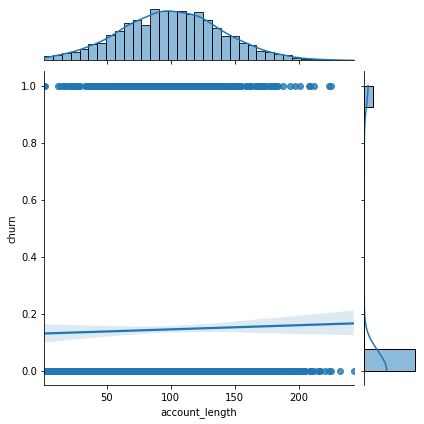

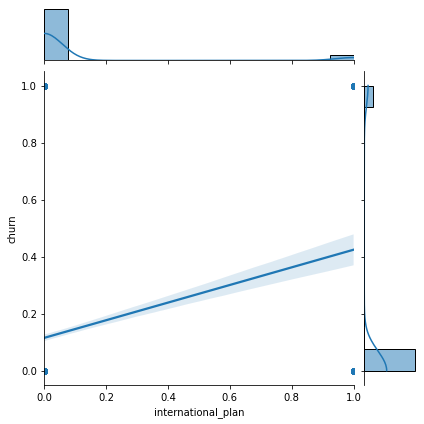

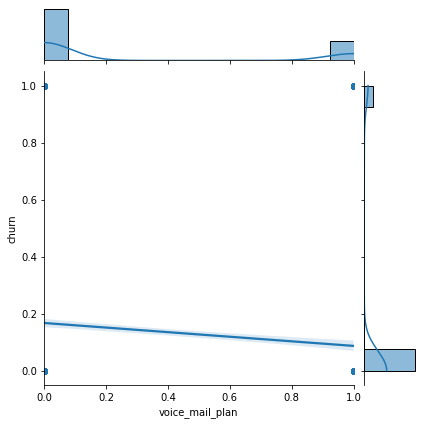

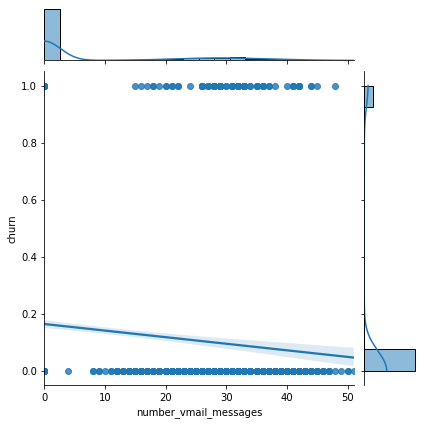

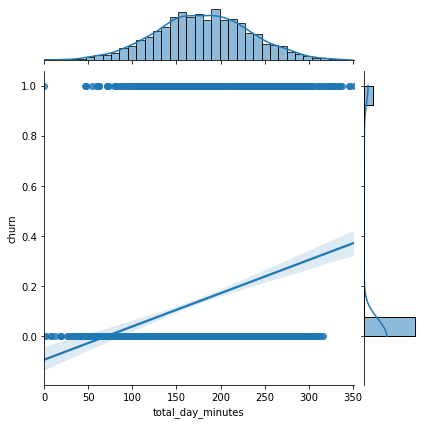

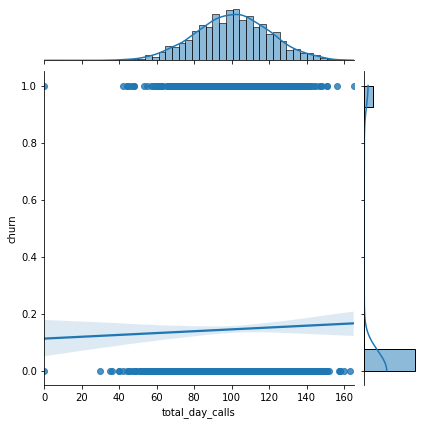

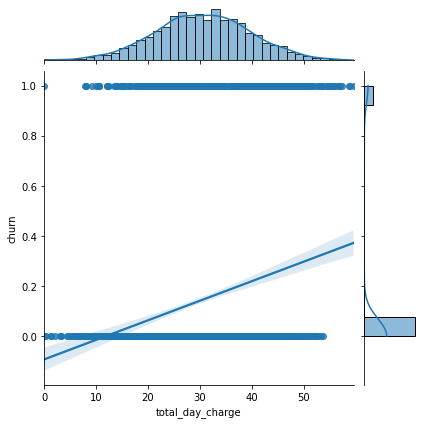

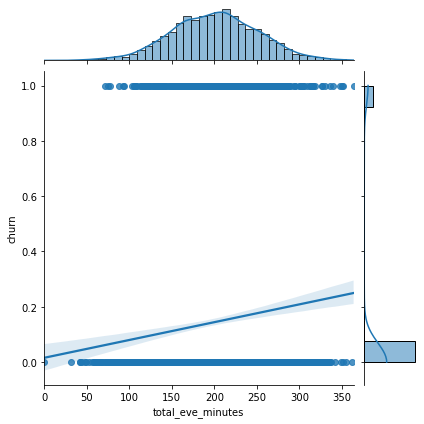

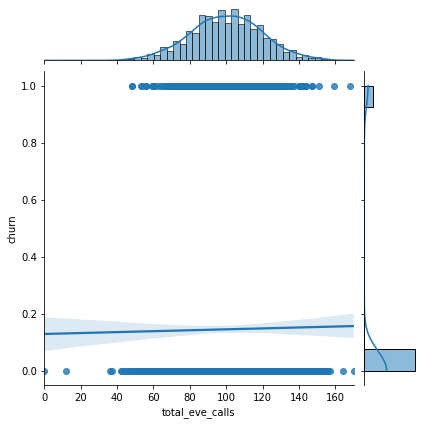

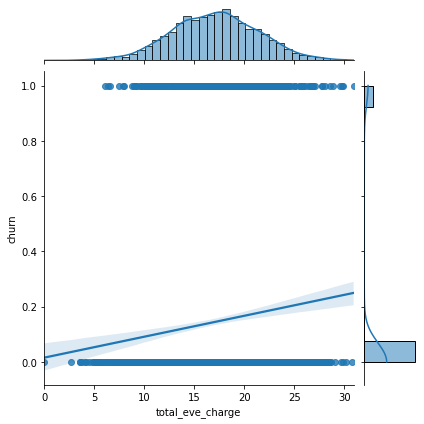

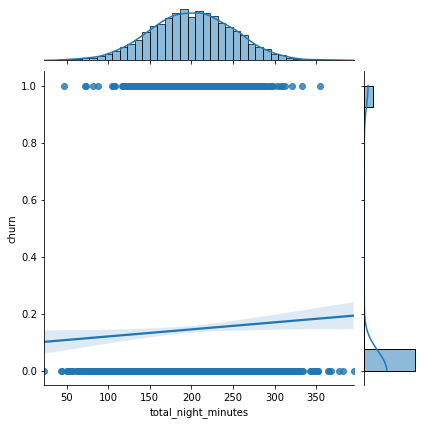

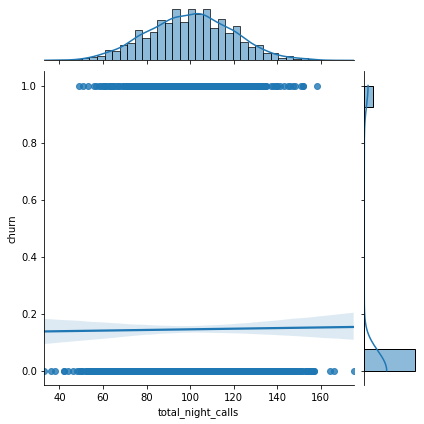

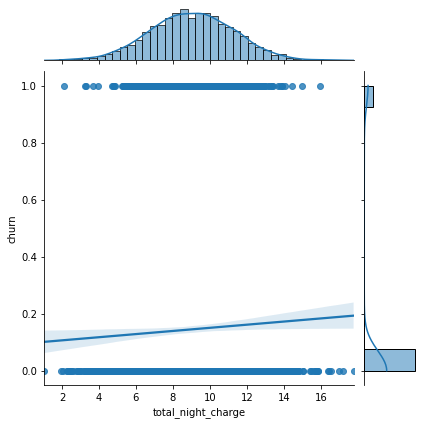

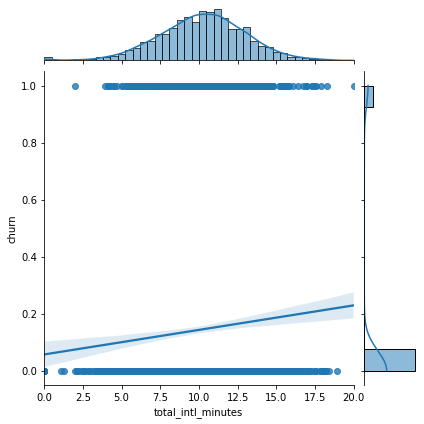

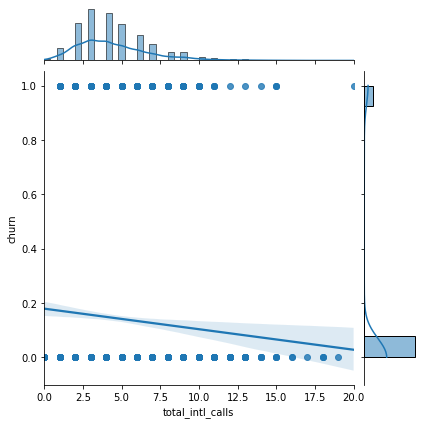

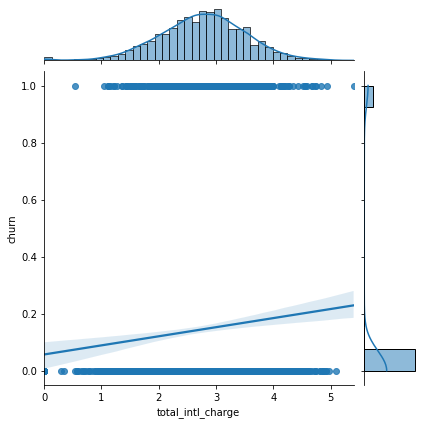

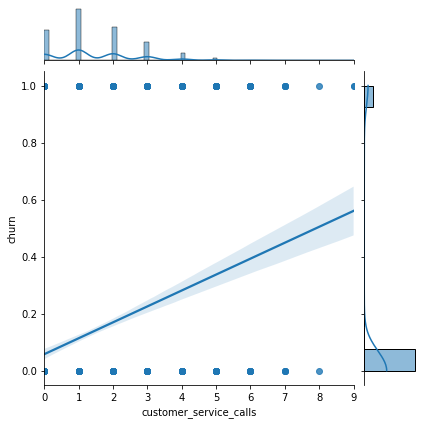

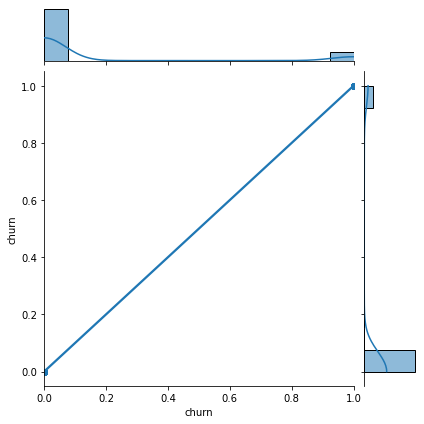

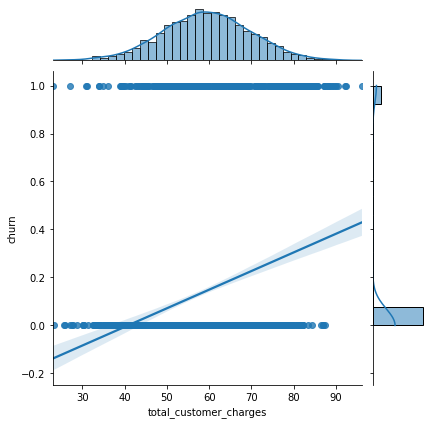

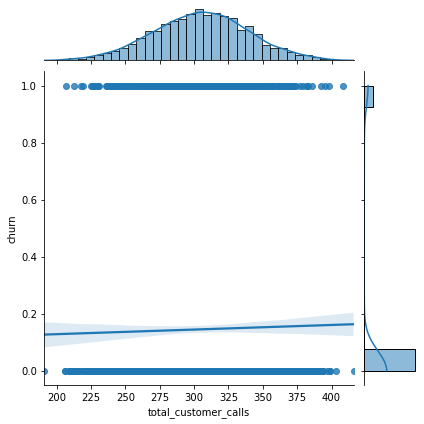

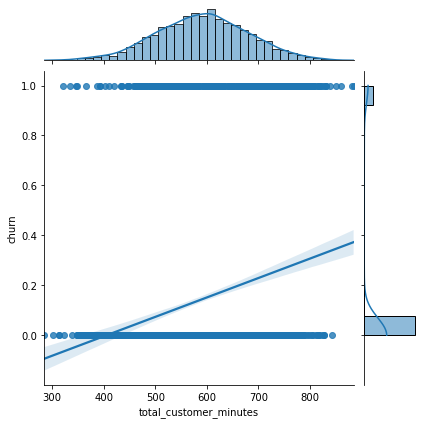

In [13]:
# Let's take a look at each column in relation with churn
for col in df.columns[1:]:
    sns.jointplot(x=col, y='churn', data=df, kind='reg');

__Observations__
* Customers with international plan seem to slightly lean towards churning
* Customers with voicemail plan seem to slightly lean towards NOT churning
* More voicemail msgs (suggesting high plan usage) slightly leans towards NOT churning
* As a general trend, the __more__ calls/minutes/charges that customers use/receives, the __more__ they are inclined to churn from SyriaTel.

Let's see how total how much time-of-day affects customer usage
* Day: 5 AM to 5 PM
* Evening: 5 PM to 9 PM
* Night: 9 PM to 4 AM

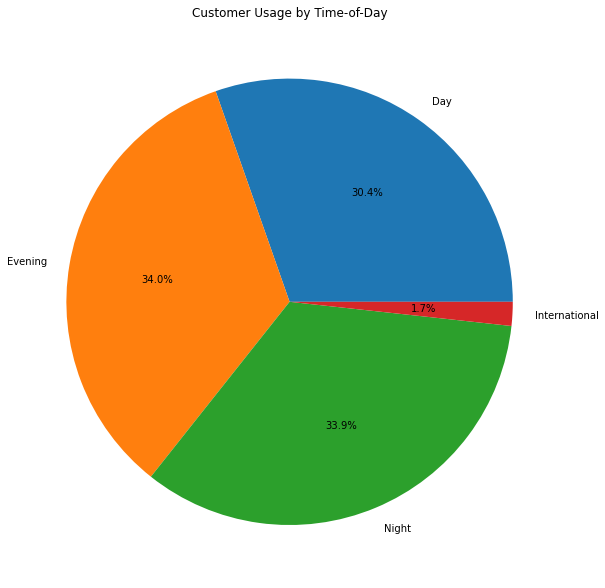

In [14]:
# Set minutes data up for pie chart
data_time = df[['total_day_minutes','total_eve_minutes','total_night_minutes','total_intl_minutes']].sum(axis = 0, skipna =True)
data_time.rename(index={"total_day_minutes": "Day", "total_eve_minutes": "Evening", "total_night_minutes": "Night", "total_intl_minutes":"International"}, inplace=True)

# Plot
pie, ax = plt.subplots(figsize=[10,20])
labels = data_time.index
plt.pie(data_time, labels=labels, autopct='%1.1f%%')
plt.title('Customer Usage by Time-of-Day')
plt.show()

* Surprisingly, each part of the day is equally spent on calls
* Customers spend most of their calls in the latter part of the day (Evening + Night)

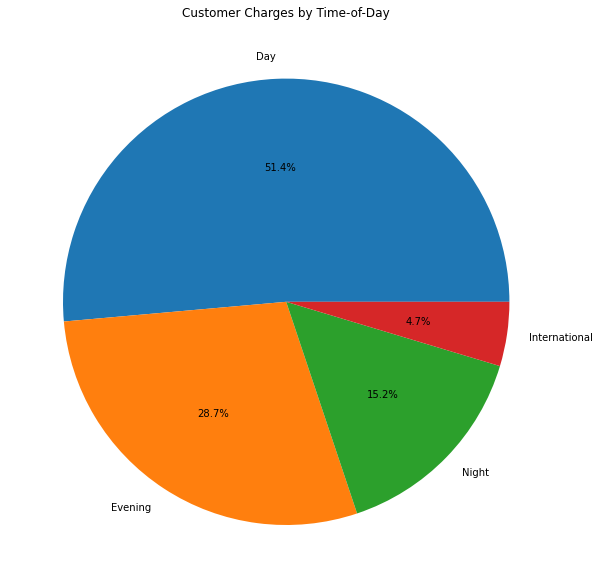

In [15]:
# Set data up for pie chart
data_charges = df[['total_day_charge','total_eve_charge','total_night_charge','total_intl_charge']].sum(axis = 0, skipna =True)
data_charges.rename(index={"total_day_charge": "Day", "total_eve_charge": "Evening", "total_night_charge": "Night", "total_intl_charge":"International"}, inplace=True)

# Plot
pie, ax = plt.subplots(figsize=[10,20])
labels = data_charges.index
plt.pie(data_charges, labels=labels, autopct='%1.1f%%')
plt.title('Customer Charges by Time-of-Day')
plt.show()

* Despite most usages being at Night and Evening, the total customer charges are the largest for day. 
* It may be better to reduce the Day time charges and increase the Evening and Night time charges as it will lead to larger profits.

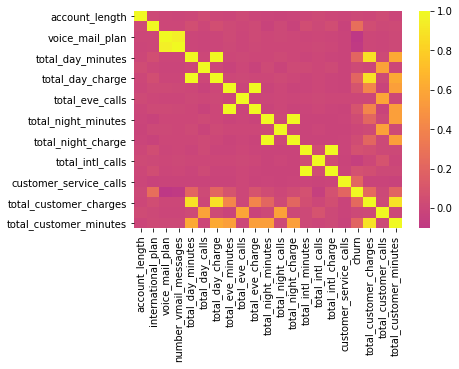

In [16]:
# Heatmap for correlation values
import seaborn as sns
sns.heatmap(df.corr(), cmap='plasma', center=0);

There appears to be be some heavy multicollinearity between some factors. Let's identify which ones are causing an issue

In [17]:
# Displays if correlation coefficient values is greater than 0.75
df.corr()
abs(df.corr()) > 0.75

# Finds which column pairs have a CC values > 0.75
df_mc = df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

df_mc['pairs'] = list(zip(df_mc.level_0, df_mc.level_1))

df_mc.set_index(['pairs'], inplace = True)

df_mc.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
df_mc.columns = ['cc']

df_mc.drop_duplicates(inplace=True)

df_mc[(df_mc.cc>.75) & (df_mc.cc<1)]

,cc
pairs,
"(total_day_charge, total_day_minutes)",1.000000
"(total_eve_minutes, total_eve_charge)",1.000000
"(total_night_charge, total_night_minutes)",0.999999
"(total_intl_minutes, total_intl_charge)",0.999993
"(voice_mail_plan, number_vmail_messages)",0.956927
"(total_customer_charges, total_customer_minutes)",0.890804
"(total_customer_charges, total_day_charge)",0.884757
"(total_customer_charges, total_day_minutes)",0.884754


* Let's get rid of the factors related to minutes and keep the charge factors. Price is more important to our overall analysis
* We will also remove number_vmail_messages as the more important factor is that they have a voicemail plan.

In [18]:
# Dropping total_day_minutes, total_eve_minutes, total_night_minutes, total_intl_minutes, number_vmail_messages, and total_customer_minutes
df.drop(['total_day_minutes','total_eve_minutes','total_night_minutes','total_intl_minutes','number_vmail_messages','total_customer_minutes'], axis = 1, inplace=True)

In [19]:
# Final Cleaned data
df.head()

,state,account_length,international_plan,voice_mail_plan,total_day_calls,total_day_charge,total_eve_calls,total_eve_charge,total_night_calls,total_night_charge,total_intl_calls,total_intl_charge,customer_service_calls,churn,total_customer_charges,total_customer_calls
0,KS,128,0,1,110,45.07,99,16.78,91,11.01,3,2.70,1,0,75.56,303
1,OH,107,0,1,123,27.47,103,16.62,103,11.45,3,3.70,1,0,59.24,332
2,NJ,137,0,0,114,41.38,110,10.30,104,7.32,5,3.29,0,0,62.29,333
3,OH,84,1,0,71,50.90,88,5.26,89,8.86,7,1.78,2,0,66.80,255
4,OK,75,1,0,113,28.34,122,12.61,121,8.41,3,2.73,3,0,52.09,359


## Modeling

Now that we have explored the cleaned data, we can finally move on to create models to properly see the effects of each of the factors on telecom customer churning.

### Model Training/Test data

In [20]:
# Create categories
df_dummy = pd.get_dummies(df)
df_dummy.head()

,account_length,international_plan,voice_mail_plan,total_day_calls,total_day_charge,total_eve_calls,total_eve_charge,total_night_calls,total_night_charge,total_intl_calls,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,128,0,1,110,45.07,99,16.78,91,11.01,3,...,0,0,0,0,0,0,0,0,0,0
1,107,0,1,123,27.47,103,16.62,103,11.45,3,...,0,0,0,0,0,0,0,0,0,0
2,137,0,0,114,41.38,110,10.30,104,7.32,5,...,0,0,0,0,0,0,0,0,0,0
3,84,1,0,71,50.90,88,5.26,89,8.86,7,...,0,0,0,0,0,0,0,0,0,0
4,75,1,0,113,28.34,122,12.61,121,8.41,3,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# Create X,y and train/test
X = df_dummy.drop(columns=['churn'], axis=1)
y = df_dummy['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 10)

### Class Imbalance

In [22]:
df['churn'].value_counts()

0    2850
1     483
Name: churn, dtype: int64

In [23]:
# SMOTE
smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

### Logistic Regression

In [24]:
# Logistic Regression model
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log = logreg.fit(X_train_sm, y_train_sm)

In [25]:
# Prediction
y_hat_train = logreg.predict(X_train_sm)
y_hat_test = logreg.predict(X_test)

In [26]:
display(model_log.score(X_train_sm, y_train_sm))
display(model_log.score(X_test, y_test))

0.9218612818261633

0.8620689655172413

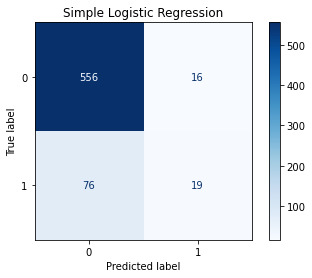

In [27]:
# Plot confusion matrix
plot_confusion_matrix(model_log, X_test, y_test,cmap=plt.cm.Blues)
plt.title('Simple Logistic Regression')
plt.show()

In [28]:
# we compute our validation metric, recall

print('Training Precision: ', precision_score(y_train_sm, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('\n\n')

print('Training Recall: ', recall_score(y_train_sm, y_hat_train))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('\n\n')

print('Training Accuracy: ', accuracy_score(y_train_sm, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('\n\n')

print('Training F1-Score: ', f1_score(y_train_sm, y_hat_train))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))

Training Precision:  0.9674124513618677
Testing Precision:  0.5428571428571428



Training Recall:  0.8731343283582089
Testing Recall:  0.2



Training Accuracy:  0.9218612818261633
Testing Accuracy:  0.8620689655172413



Training F1-Score:  0.9178587909552376
Testing F1-Score:  0.29230769230769227


* We want to focus on __Recall__ as our main model metric because we want to focus on predicting whether or not a customer is going to churn 
* Recall is 87% for Training and 20% for Test. The test score is extremely low. A new model classifier will be needed 
* The training score is higher than the recall score, thus is __NOT Overfitting__.

### Random Forest

In [29]:
# Set up initial forest
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train_sm, y_train_sm)

DecisionTreeClassifier()

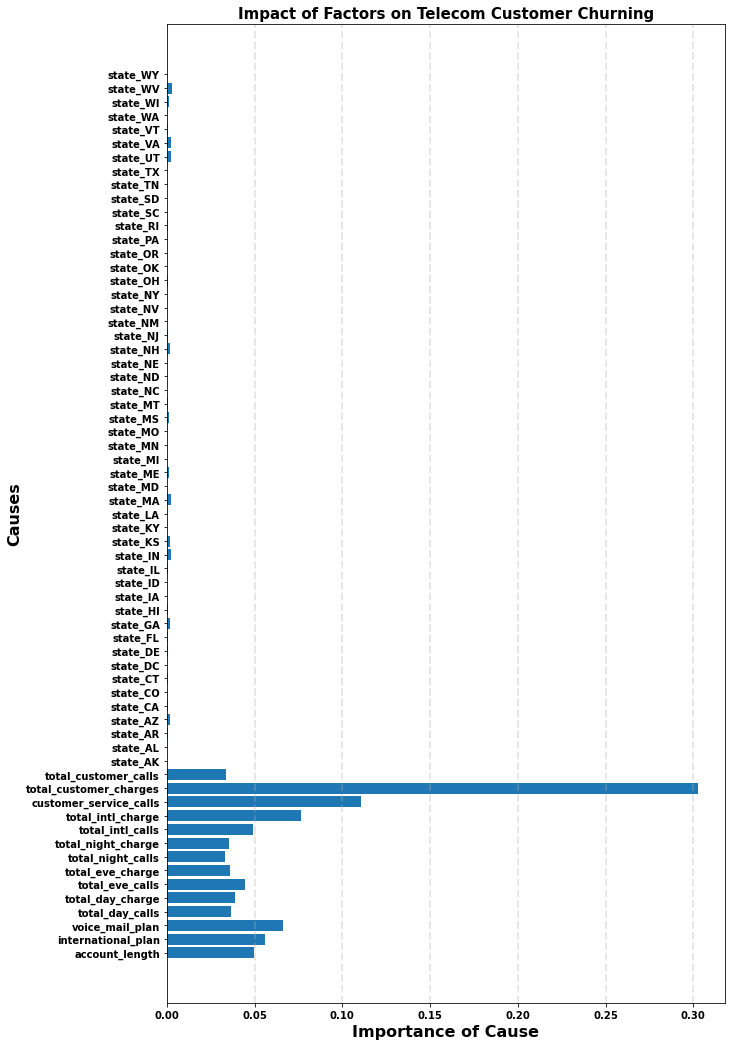

In [30]:
# Plotting feature importance of models
def plot_feature_importances(model):
    n_features = X_train_sm.shape[1]
    plt.figure(figsize=(10,18))
    plt.barh(range(n_features), model.feature_importances_) 
    plt.xticks(fontsize=10, fontweight='bold')
    plt.yticks(np.arange(n_features), X_train_sm.columns.values, fontsize=10, fontweight='bold') 
    plt.xlabel('Importance of Cause', fontsize=16, fontweight='bold' )
    plt.ylabel('Causes',fontsize=16, fontweight='bold')
    plt.grid(linestyle='--', linewidth=2, axis='x', alpha=0.3)
    plt.title("Impact of Factors on Telecom Customer Churning", fontsize=15, fontweight='bold')

plot_feature_importances(tree_clf)

In [31]:
# Test set predictions
val = tree_clf.predict(X_train_sm)
pred = tree_clf.predict(X_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print('Training Recall: ', recall_score(y_train_sm, val)*100)
print('Testing Recall: ', recall_score(y_test, pred)*100)

[[475  97]
 [ 18  77]]
              precision    recall  f1-score   support

           0       0.96      0.83      0.89       572
           1       0.44      0.81      0.57        95

    accuracy                           0.83       667
   macro avg       0.70      0.82      0.73       667
weighted avg       0.89      0.83      0.85       667

Training Recall:  100.0
Testing Recall:  81.05263157894737


* Not Overfitting

In [32]:
# Random Forest
forest = RandomForestClassifier()
forest.fit(X_train_sm, np.ravel(y_train_sm))

RandomForestClassifier()

In [33]:
# Finding the best parameters
param_grid = {
    'max_depth': [2, 5, 10, 25],
    'min_samples_split': [2, 5, 10, 20]
}

gs_tree = GridSearchCV(forest, param_grid, cv=3, scoring='recall')
gs_tree.fit(X_train_sm, np.ravel(y_train_sm))

gs_tree.best_params_

{'max_depth': 25, 'min_samples_split': 2}

In [34]:
# Applying best Random Forest parameters
forest = RandomForestClassifier(max_depth=25, min_samples_split=2)
forest.fit(X_train_sm, np.ravel(y_train_sm))

vals = forest.predict(X_train_sm)
preds = forest.predict(X_test)

print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))
print('Training Recall: ', recall_score(y_train_sm, vals)*100)
print('Testing Recall: ', recall_score(y_test, preds)*100)

[[552  20]
 [ 21  74]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       572
           1       0.79      0.78      0.78        95

    accuracy                           0.94       667
   macro avg       0.88      0.87      0.87       667
weighted avg       0.94      0.94      0.94       667

Training Recall:  100.0
Testing Recall:  77.89473684210526


* Our Confusion matrix is looking better than before. Predicting more True churns than False churns
* Training Recall score is higher than test. __Not Overfitting__
* Testing Recall score is still low (76%).
* Should keep looking for a better Classifier

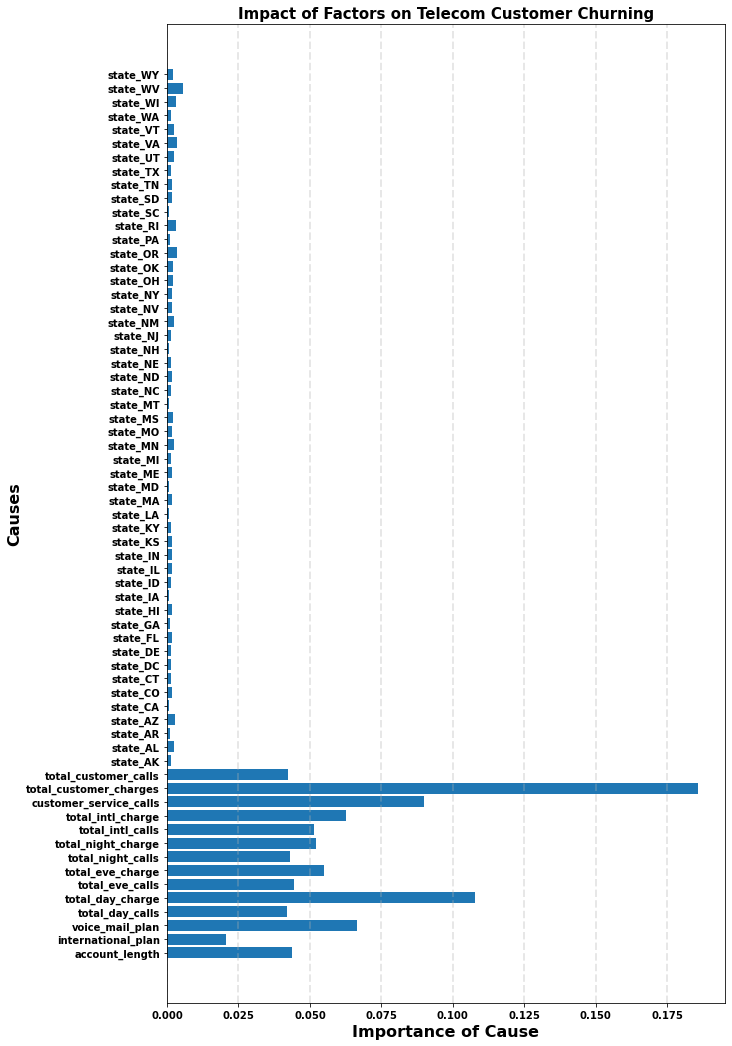

In [35]:
plot_feature_importances(forest)

* The individual states do not seem to have a large influence on the customer churn
* __Total customer charges___ and __total day charge__ appears to have the largest influence on churn

### XG Boost

In [36]:
# Instantiate XGBClassifier
xgb = XGBClassifier()

# Fit XGBClassifier
xgb.fit(X_train_sm, np.ravel(y_train_sm))

# Predict on training and test sets
training_preds = xgb.predict(X_train_sm)
test_preds = xgb.predict(X_test)

# Accuracy of training and test sets
training_recall = recall_score(y_train_sm, training_preds)
test_recall = recall_score(y_test, test_preds)

print('Training Recall: {:.4}%'.format(training_recall * 100))
print('Test Recall: {:.4}%'.format(test_recall * 100))

Training Recall: 98.95%
Test Recall: 82.11%


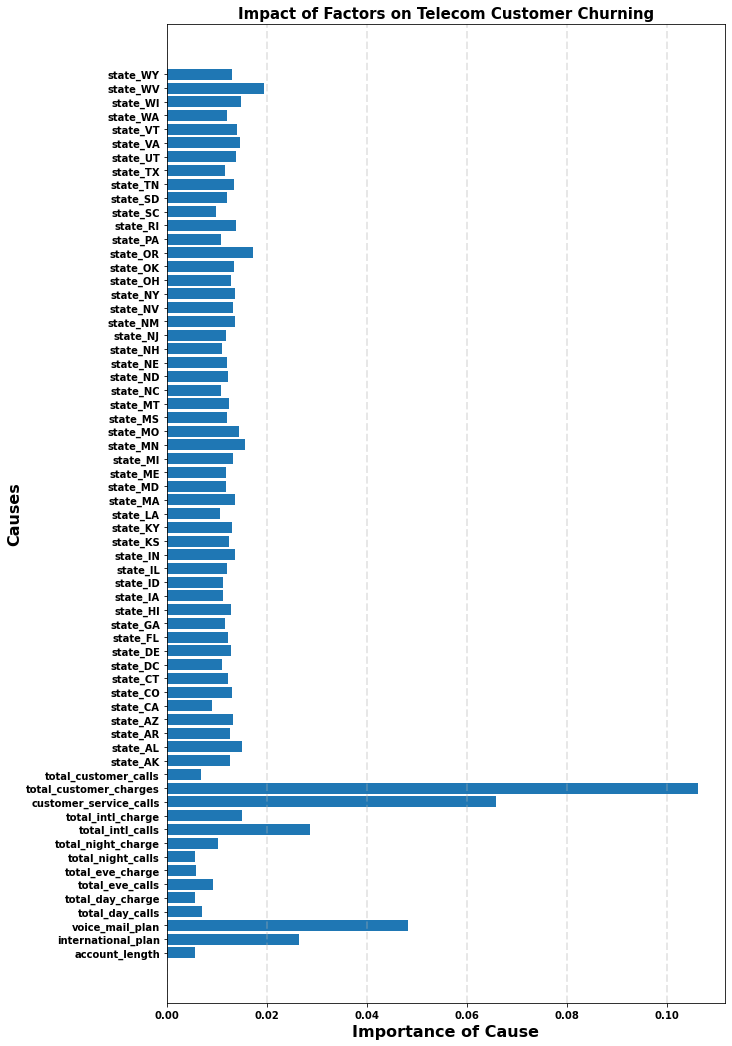

In [37]:
plot_feature_importances(xgb)

In [38]:
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

grid_clf = GridSearchCV(xgb, param_grid, scoring='recall')
grid_clf.fit(X_train_sm, np.ravel(y_train_sm))

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train_sm)
test_preds = grid_clf.predict(X_test)

training_recall = recall_score(y_train_sm, training_preds)
test_recall = recall_score(y_test, test_preds)

print('')
print('Training Recall: {:.4}%'.format(training_recall * 100))
print('Test Recall: {:.4}%'.format(test_recall * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.2
max_depth: 6
min_child_weight: 1
n_estimators: 100
subsample: 0.7

Training Recall: 97.67%
Test Recall: 81.05%


In [39]:
print(confusion_matrix(y_test, test_preds))
print(classification_report(y_test, test_preds))
print('')
print('Training Recall: {:.4}%'.format(training_recall * 100))
print('Test Recall: {:.4}%'.format(test_recall * 100))

[[561  11]
 [ 18  77]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       572
           1       0.88      0.81      0.84        95

    accuracy                           0.96       667
   macro avg       0.92      0.90      0.91       667
weighted avg       0.96      0.96      0.96       667


Training Recall: 97.67%
Test Recall: 81.05%


* Confusion Matrix shows a great True Churn prediction rate compared to False Churn.
* Higher Training recall than Test recall. __Not Overfitting__
* __XG Boost has the highest testing Recall from the previous models.__
* We shall use this for our predictive analysis

### Final Model Selection

In [40]:
df_final = pd.DataFrame(xgb.feature_importances_, X.columns, columns = ['coefficient'])
df_final.head()

,coefficient
account_length,0.005636
international_plan,0.026481
voice_mail_plan,0.048244
total_day_calls,0.006943
total_day_charge,0.005589


In [41]:
df_final_detail = df_final[:14]
display(df_final_detail.head())
df_final_state = df_final[14:]
display(df_final_state.head())

,coefficient
account_length,0.005636
international_plan,0.026481
voice_mail_plan,0.048244
total_day_calls,0.006943
total_day_charge,0.005589


,coefficient
state_AK,0.012553
state_AL,0.015029
state_AR,0.012521
state_AZ,0.013282
state_CA,0.009105


In [42]:
# Renaming states indexes
as_list = df_final_state.index.values.tolist()
as_list = [i.replace('state_','') for i in as_list]
df_final_state.index = as_list
df_final_state.head()

,coefficient
AK,0.012553
AL,0.015029
AR,0.012521
AZ,0.013282
CA,0.009105


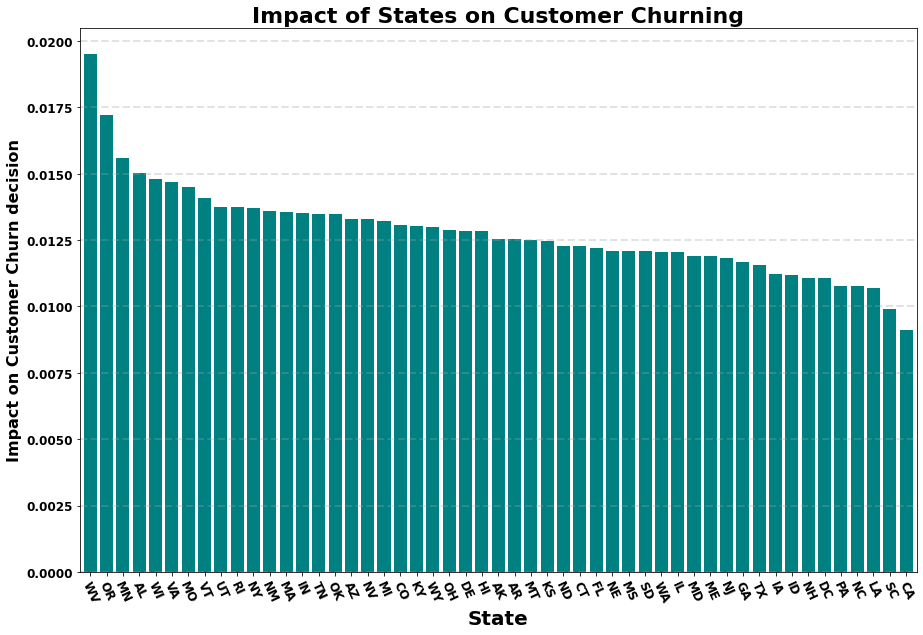

In [43]:
# Create a barplot of state's impact on churn
ax = df_final_state.sort_values(by=['coefficient'], ascending=False).plot(kind='bar', width=0.8, color = 'teal', figsize=(15,10))
ax.set_title("Impact of States on Customer Churning", fontsize = 22, fontweight = 'bold')
ax.set_xlabel("State", fontsize=20, fontweight='bold')
ax.set_ylabel("Impact on Customer Churn decision", fontsize=16, fontweight='bold');
ax.get_legend().remove()

plt.xticks(rotation=-65, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.3)

* There seems to be a slightly larger churn rate in __state_WV__. This may need to be investigated further.
* No apparent correlation can be found with states with higher impact

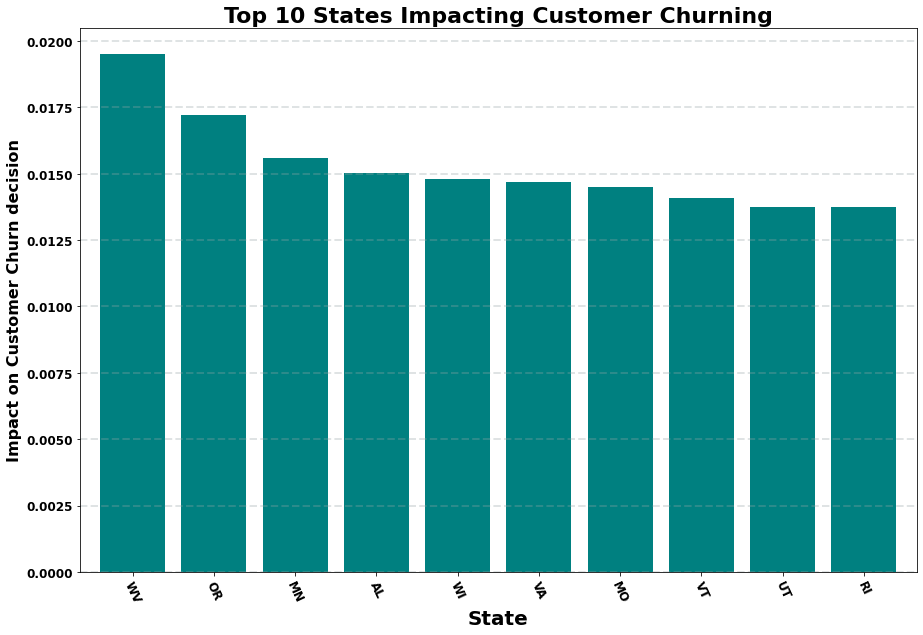

In [44]:
# Create a barplot of top 5 state's impact on churn
ax = df_final_state.sort_values(by=['coefficient'], ascending=False).head(10).plot(kind='bar', width=0.8, color = 'teal', figsize=(15,10))
ax.set_title("Top 10 States Impacting Customer Churning", fontsize = 22, fontweight = 'bold')
ax.set_xlabel("State", fontsize=20, fontweight='bold')
ax.set_ylabel("Impact on Customer Churn decision", fontsize=16, fontweight='bold');
ax.get_legend().remove()

plt.xticks(rotation=-65, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.3)

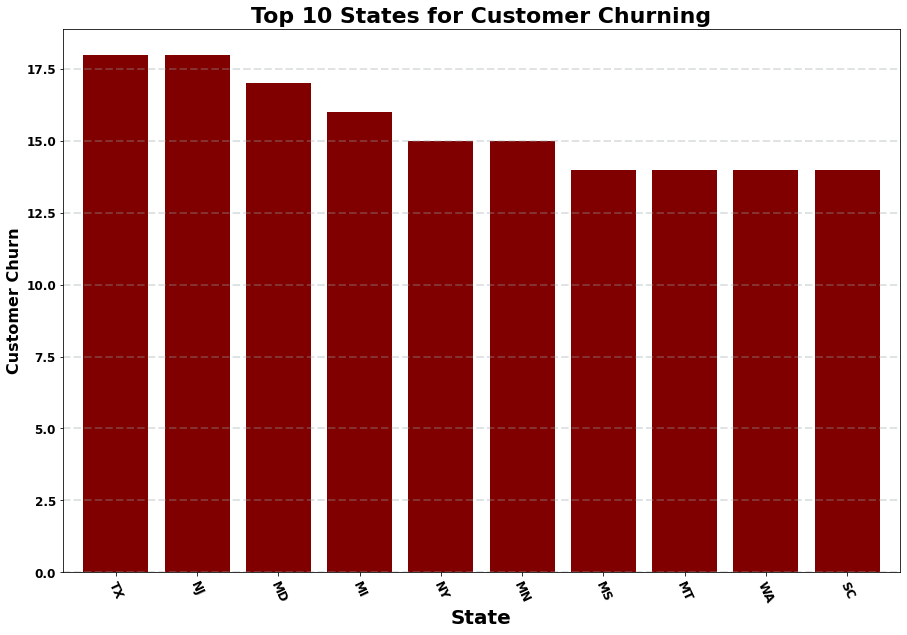

In [45]:
# Create a barplot of top 5 state's churn based on original dataset
ax = df.groupby(['state']).sum().churn.sort_values(ascending=False).head(10).plot(kind='bar', width=0.8, color = 'maroon', figsize=(15,10))
ax.set_title("Top 10 States for Customer Churning", fontsize = 22, fontweight = 'bold')
ax.set_xlabel("State", fontsize=20, fontweight='bold')
ax.set_ylabel("Customer Churn", fontsize=16, fontweight='bold');

plt.xticks(rotation=-65, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.3)

* Original Data set results for top churn and model feature importance appear to be showing different results
* Will need further investigation on individual state's impact on churn

In [46]:
# Renaming detail indexes
detail_list = df_final_detail.index.values.tolist()
detail_list = [i.replace('_',' ') for i in detail_list]
df_final_detail.index = detail_list
df_final_detail.head()

,coefficient
account length,0.005636
international plan,0.026481
voice mail plan,0.048244
total day calls,0.006943
total day charge,0.005589


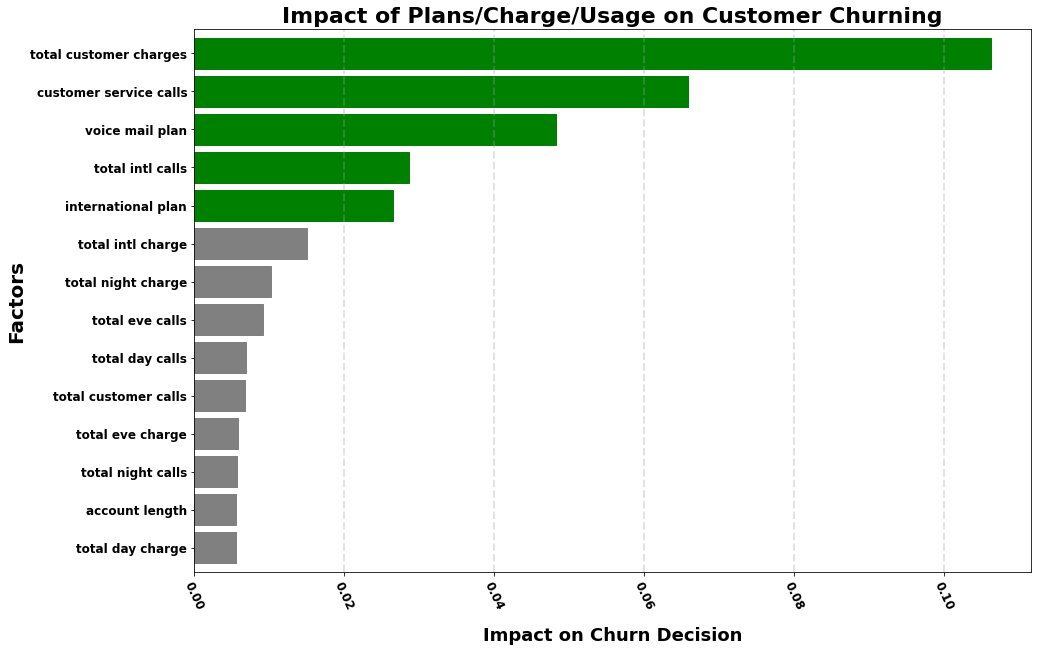

In [47]:
# Create a barplot of customer plans/usage's impact on churn
ax = df_final_detail.sort_values(by=['coefficient'], ascending=True).plot(kind='barh', width=0.8, color = 'teal', figsize=(15,10))
ax.set_title("Impact of Plans/Charge/Usage on Customer Churning", fontsize = 22, fontweight = 'bold')
ax.set_ylabel("Factors", fontsize=20, fontweight='bold')
ax.set_xlabel("Impact on Churn Decision", fontsize=18, fontweight='bold', labelpad= 15);
ax.get_legend().remove()

for column in ax.patches:
    if column.get_width() > 0.02:
        column.set_color('green')    
    else:
        column.set_color('grey')

plt.xticks(rotation=-65, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='x', alpha=0.3)

* __total_customer_charges__ appear to be the largest cause of churn. This makes sense seeing that most customers 
* __customer_service_calls__ come 2nd influence to the plans. There may need to be an improvement to the customer service section of the company.
* __voice_mail_plan__ and __international_plan__ are the relatively high factors to customer churn. There may be some issues with how both plans are being handled.


## Conclusions

The analysis of the SyriaTel customer churn dataset resulted in the following conclusions:
* There needs to be an improvement to the __Voice mail plan__ and  __International plan__. The customer churn is heavily affected by the effectiveness of the plans. These plans need to be further examined to entice customers to stay with SyriaTel.
* The __Customer service__ department may need examining. We need to check staffing to see what is causing the customers to turn away from SyriaTel as they submit for help through the customer service line.
* We can predict future customer churn with our final model. This should help us mitigate customer losses if we contact the customer earlier for their input.

## Recommendations

What can we do right now?
* __We can adjust the minute-to-charge rates for day-evening-night.__ The high total charges appear to be causing the most impact on SyriaTel customer's churning. Despite most of our customers utilizing around 2/3 of their total minutes in the evening and night, the day-time charges overtake the two charges combined. We may be able to get more customer satisfaction from them knowing that their charges in the day-time are being lowered, despite most of their minutes are spent in the evening. This will allow us to maintain profits from call charges while maintaining a lower churn.
* __Increase the staffing of the Customer Service department.__ Increased staffing will readily make available more customers to be directly in line with staff. This will increase customer satisfaction. Additionally, more staffing may help us identify the common issues customers are having more quickly, allowing SyriaTel to address specific issues quickly as well. Overall, customer churn should go down. 
* __Reduce the charge of international calls/plan__ This will reduce customer churn over the factors of the international plan and its charges. It is not worth losing a customer over a specific plan they have chosen. We should keep the customer to profit off of the general uses outside of the international plan. 

## Next Steps

Further analysis of the SyriaTel data could yield additional insights to other recommendations
* __Locate what factors are causing a larger churn impact within specific states__
* __Create an alert system that detects when individual customer are in range of possibly churning__
* __Investigate a change over system from international to domestic plans on customer churn__